Scores de risque sur chaque arête :
A -> B : 0.26
B -> C : 0.78
C -> A : 0.22
D -> A : 0.80
D -> E : 0.57
E -> F : 0.73
Cycle négatif détecté dans le graphe (activité frauduleuse possible)!

 Résultats de l'algorithme de Bellman-Ford :
Nœud source : A
Distance de A à A : -5
Chemin : A -> C -> B -> ... (cycle)

Distance de A à B : -3
Chemin : B -> A -> C -> ... (cycle)

Distance de A à C : -6
Chemin : C -> B -> A -> ... (cycle)

Distance de A à D : inf
Chemin : D

Distance de A à E : inf
Chemin : E

Distance de A à F : inf
Chemin : F

Cycle négatif détecté.

Nœuds anormaux détectés (betweenness, threshold=2) : []
Arêtes anormales détectées (threshold=2) : []


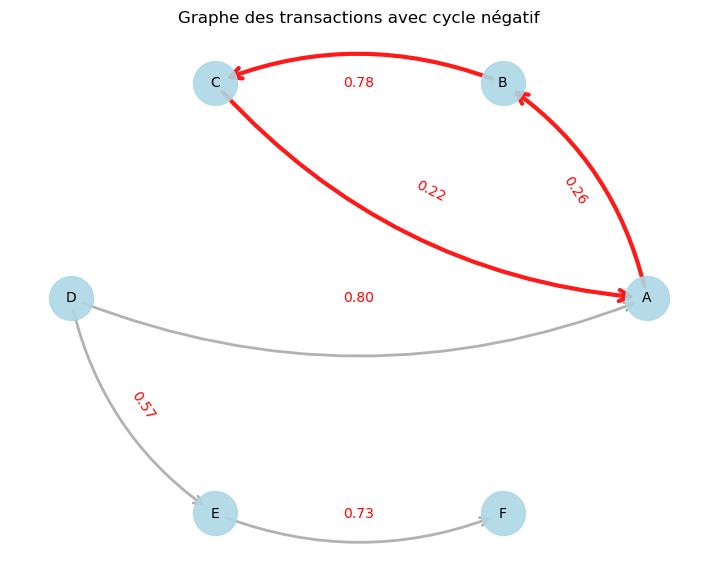

In [16]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np

# data synthetique fait à la main pour simplifier le problème
def data_synthetique():
    data = [{'nameOrig': 'A', 'nameDest': 'B', 'amount': 1, 'isFraud': 1},{'nameOrig': 'B', 'nameDest': 'C', 'amount': -3, 'isFraud': 1},{'nameOrig': 'C', 'nameDest': 'A', 'amount': 1, 'isFraud': 1},{'nameOrig': 'D', 'nameDest': 'A', 'amount': 5, 'isFraud': 0},{'nameOrig': 'D', 'nameDest': 'E', 'amount': 2, 'isFraud': 0},{'nameOrig': 'E', 'nameDest': 'F', 'amount': 3, 'isFraud': 0},]
    return pd.DataFrame(data)

# On construit un graphe orienté pour les transactions, weight c'est le montant de la transations , fraud vaut 0(pas fraude) ou 1(fraude) 
def graph_oriente(df):
    """
    Construit un graphe orienté à partir du DataFrame de transactions.
    
    Pour chaque transaction, une arête est ajoutée avec :
      - 'weight' : le montant de la transaction.
      - 'fraud'  : un indicateur binaire (1 pour frauduleux, 0 sinon).
    """
    G = nx.DiGraph()
    for _, row in df.iterrows():
        G.add_edge(
            row['nameOrig'],
            row['nameDest'],
            weight=row['amount'],
            fraud=row['isFraud']
        )
    return G

# ajout d'un score de risque ( on a choisi ici 0 ou 1 pour simplifier) qui indique le risque qu'il s'agit d'une fraude
def add_random_risk_scores(G):
    for u, v, data in G.edges(data=True):
        data['risk_score'] = random.uniform(0, 1)
    return G

#l'algorithme de Bellman-Ford calcule le pcc depuis un noeud et capable de détecter un cycle négatif
def bellman_ford(G, source, weight_attr='weight'):

    # Pour chaque nœud, on initialise la distance à l'infini et le prédécesseur à None.
    distances = {node: float('inf') for node in G.nodes()}
    predecessor = {node: None for node in G.nodes()}
    # La distance de la source est de 0.
    distances[source] = 0

    nb_noeuds = len(G.nodes())

    # 2. Phase itérative
    # On effectue Noeuds - 1 itérations pour tenter d'améliorer les distances.
    for i in range(nb_noeuds - 1):
        for u, v, data in G.edges(data=True):
            # On récupère le poids de l'arête, avec une valeur par défaut de 1
            poids = data.get(weight_attr, 1)
            # Si le chemin passant par u a une distance plus courte à v, on met à jour :
            if distances[u] + poids < distances[v]:
                distances[v] = distances[u] + poids
                predecessor[v] = u


    # Si une arête permet encore d'améliorer une distance :il y a un cycle négatif.
    cycle_negatif = False
    for u, v, data in G.edges(data=True):
        poids = data.get(weight_attr, 1)
        if distances[u] + poids < distances[v]:
            print("Cycle négatif détecté dans le graphe (activité frauduleuse possible)!")
            cycle_negatif = True
            break

    # On reconstruit le chemin à partir de la source
    # Pour chaque nœud, on remonte via le dictionnaire 'predecessor' pour obtenir le chemin.
    # On utilise un set 'visited' pour éviter les boucles infinies en cas de cycle.
    chemins = {}
    for node in G.nodes():
        chemin = []
        current = node
        visited = set()
        while current is not None and current not in visited:
            visited.add(current)
            chemin.append(current)
            current = predecessor[current]
        # Si un cycle est détecté (current non nul), on l'indique dans le chemin
        if current is not None:
            chemin.append("... (cycle)")
        chemins[node] = chemin

    return distances, chemins, cycle_negatif

#Utilise l'algorithme de Louvain pour détecter des communautés dans le graphe.
def detect_communities_louvain(G):
    G_non = G.to_undirected()
    import community as community_louvain  # nécessite python-louvain
    partition = community_louvain.best_partition(G_non, weight='weight')
    return partition


# Détection d'anomalies par centralité (nœuds et arêtes)
def detect_anomaly_nodes(G, centrality_measure='betweenness', threshold_factor=2):
    """
    Détecte les nœuds anormaux selon une mesure de centralité.
    
    Un nœud est considéré comme anormal si sa centralité dépasse la moyenne plus
    'threshold_factor' fois l'écart-type.
    
    Retourne :
      - anomalies (list) : Liste des nœuds anormaux.
      - centralities (dict) : Valeurs de centralité pour chaque nœud.
    """
    if centrality_measure == 'degree':
        centralities = nx.degree_centrality(G)
    elif centrality_measure == 'betweenness':
        centralities = nx.betweenness_centrality(G)
    elif centrality_measure == 'closeness':
        centralities = nx.closeness_centrality(G)
    else:
        raise ValueError("centrality_measure doit être 'degree', 'betweenness' ou 'closeness'")
    
    values = np.array(list(centralities.values()))
    mean_val = values.mean()
    std_val = values.std()
    threshold = mean_val + threshold_factor * std_val
    
    anomalies = [node for node, val in centralities.items() if val > threshold]
    return anomalies, centralities

def detect_anomaly_edges(G, threshold_factor=2):
    """
    Détecte les arêtes anormales en se basant sur la betweenness des arêtes.
    
    Une arête est considérée comme anormale si sa betweenness dépasse la moyenne plus
    'threshold_factor' fois l'écart-type.
    
    Retourne :
      - anomalies (list) : Liste des arêtes anormales.
      - edge_centralities (dict) : Valeurs de betweenness pour chaque arête.
    """
    edge_centralities = nx.edge_betweenness_centrality(G)
    values = np.array(list(edge_centralities.values()))
    mean_val = values.mean()
    std_val = values.std()
    threshold = mean_val + threshold_factor * std_val
    
    anomalies = [edge for edge, val in edge_centralities.items() if val > threshold]
    return anomalies, edge_centralities

# Code principal 

df = data_synthetique()
graphe = graph_oriente(df)
graphe = add_random_risk_scores(graphe)

print("Scores de risque sur chaque arête :")
for u, v, d in graphe.edges(data=True):
    print(f"{u} -> {v} : {d['risk_score']:.2f}")

# l'algorithme de Bellman-Ford à partir d'un nœud aléatoire
source = 'A'
distances, chemins, cycle_negatif = bellman_ford(graphe, source, weight_attr='weight')

print("\n Résultats de l'algorithme de Bellman-Ford :")
print(f"Nœud source : {source}")
for node in distances:
    print(f"Distance de {source} à {node} : {distances[node]}")
    print(f"Chemin : {' -> '.join(chemins[node])}\n")
if cycle_negatif:
    print("Cycle négatif détecté.\n")
else:
    print("Aucun cycle négatif détecté.\n")

# Détection d'anomalies sur les nœuds avec un seuil = 2
anomalies_nodes, centralities = detect_anomaly_nodes(graphe, centrality_measure='betweenness', threshold_factor=2)
print("Nœuds anormaux détectés (betweenness, threshold=2) :", anomalies_nodes)

# Détection d'anomalies sur les arêtes avec un seuil = 2
anomalies_edges, edge_centralities = detect_anomaly_edges(graphe, threshold_factor=2)
print("Arêtes anormales détectées (threshold=2) :", anomalies_edges)

# Visualisation
pos = nx.circular_layout(graphe)
plt.figure(figsize=(9, 7))

nx.draw_networkx_nodes(graphe, pos, node_color="lightblue", node_size=1000, alpha=0.9)
nx.draw_networkx_labels(graphe, pos, font_size=10, font_color="black")

#les arêtes normales (en gris)
all_edges = [(u, v) for u, v, d in graphe.edges(data=True) if d["fraud"] == 0]
nx.draw_networkx_edges(graphe, pos, edgelist=all_edges, edge_color="gray",width=2,alpha=0.6, arrows=True,arrowstyle='->',arrowsize=15,connectionstyle='arc3, rad=0.2')

#les arêtes frauduleuses (en rouge)
fraud_edges = [(u, v) for u, v, d in graphe.edges(data=True) if d["fraud"] == 1]
nx.draw_networkx_edges(graphe, pos,edgelist=fraud_edges,edge_color="red",width=3,alpha=0.9,arrows=True,arrowstyle='->',arrowsize=20,connectionstyle='arc3, rad=0.2')

#les scores de risque sur les arêtes
edge_labels = {(u, v): f"{d['risk_score']:.2f}" for u, v, d in graphe.edges(data=True)}
nx.draw_networkx_edge_labels(graphe, pos, edge_labels=edge_labels, font_color='red', label_pos=0.5)
plt.title("Graphe des transactions avec cycle négatif")
plt.axis('off')
plt.show()
